## Experiment Setup

###  Random seed / PyTorch / Colab / CUDA related

In [1]:
import torch
import numpy as np

# Google Colab-only setup.
use_colab = True

# Is this running on Colab?
import importlib
colab_available = importlib.util.find_spec("google.colab") is not None

if use_colab and colab_available:
    # Mount my Google Drive root folder
    from google.colab import drive
    drive.mount('/content/drive')
    
    # Pyro
    !pip install pyro-ppl

    # cd to bayesian-dl-experiments directory
    %cd 'drive/My Drive/Colab Notebooks/bayesian-dl-experiments'
    !ls

# IPython reloading magic
%load_ext autoreload
%autoreload 2

# Random seeds
# Based on https://pytorch.org/docs/stable/notes/randomness.html
torch.manual_seed(682)
np.random.seed(682)

# torch.device / CUDA Setup
use_cuda = True

if use_cuda and torch.cuda.is_available():
    torch_device = torch.device('cuda')
    torch.set_default_tensor_type('torch.cuda.FloatTensor') 
    torch.backends.cudnn.deterministic = True
    # Note: https://discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936
    torch.backends.cudnn.benchmark = False
    use_pin_memory=True # Faster Host to GPU copies with page-locked memory
else:
    torch_device = torch.device('cpu')
    use_pin_memory=False

### Variable settings

In [2]:
"""
Toy dataset generation based on the experiment from 
the Probabilstic Backpropagation paper (Hernandez-Lobato & Adams, 2015)
"""
# Random seed for toy dataset
dataset_toy_random_seed = 691

# Toy dataset size
dataset_toy_size = 20

# Toy dataset x distribution (uniform) parameters
dataset_toy_x_low = -4
dataset_toy_x_high = 4

# Toy dataset y distribution (normal with noise)
dataset_toy_y_mean = 0
dataset_toy_y_std = 9

# L2 regularization strength
reg_strength = 0.1

# Epochs
n_epochs = 400

# Number of test predictions (for each data point)
n_predictions = 100

## Prepare data

### Get the data as a torch Dataset object

In [3]:
from torch.utils.data import random_split, DataLoader
from ronald_bdl import datasets

dataset = datasets.ToyDatasets(
    random_seed=dataset_toy_random_seed,
    n_samples=dataset_toy_size,
    x_low=dataset_toy_x_low,
    x_high=dataset_toy_x_high,
    y_mean=dataset_toy_y_mean,
    y_std=dataset_toy_y_std,
)

# Get the test data
X_test = torch.linspace(dataset_toy_x_low, dataset_toy_x_high, 100).reshape(100, 1)

# Print the size of the dataset
print("dataset size = " + str((len(dataset), dataset.n_features)))

dataset size = (20, 1)


## Define network

In [4]:
from ronald_bdl import models

uncertainty_methods = {}

# MC (Bernoulli) dropout
uncertainty_methods['mc_dropout'] = models.FCNetMCDropout(
    input_dim=dataset.n_features, 
    output_dim=dataset.n_targets,
    hidden_dim=100,
    n_hidden=0,
    dropout_rate=0.5,
    dropout_type='bernoulli',
)

# Variational Dropout
#uncertainty_methods['variational_dropout'] = models.FCNetMCDropout(
#    input_dim=dataset.n_features, 
#    output_dim=dataset.n_targets,
#    hidden_dim=100,
#    n_hidden=0,
#    dropout_rate=0.5,
#    dropout_type='variational',
#    dropout_variational_dim=100,
#)

# Vanilla Variational Inference
uncertainty_methods['variational_inference'] = models.FCNetPyro(
    input_dim=dataset.n_features, 
   output_dim=dataset.n_targets,
    hidden_dim=100,
    n_hidden=0,
)

# HMC (NUTS)
uncertainty_methods['hmc'] = models.FCNetPyro(
    input_dim=dataset.n_features, 
    output_dim=dataset.n_targets,
    hidden_dim=100,
    n_hidden=0,
)

## Train the network

### Train/test the model

In [5]:
import time
import pyro
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, NUTS, MCMC

for key, network in uncertainty_methods.items():
    
    # Print the method name
    print("Now running " + str(key))
    
    # Send the whole model to the selected torch.device
    network.to(torch_device)

    # Print the network structure
    print(network)
    print()

    train_loader = DataLoader(dataset, batch_size=len(dataset))
    
    # Optimizer setup
    if isinstance(network, models.FCNetMCDropout):
        # Adam optimizer
        # https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam
        # NOTE: Need to set L2 regularization from here
        optimizer = torch.optim.Adam(
            network.parameters(),
            lr=0.01,
            weight_decay=reg_strength, # L2 regularization
        )

        # Mean Squared Error for loss function to minimize
        objective = torch.nn.MSELoss()

    elif isinstance(network, models.FCNetPyro):
        if key == 'variational_inference':
            optimizer = pyro.optim.Adam({"lr": 0.01})
            svi = SVI(network.model, network.guide, optimizer, loss=Trace_ELBO(), num_samples=2000)
        elif key == 'hmc':
            nuts_kernel = NUTS(network.model)
            mcmc = MCMC(nuts_kernel, num_samples=2000, warmup_steps=100)

        pyro.clear_param_store()
    
    """
    Training
    """
    # Model to train mode
    network.train()

    # Record training start time (for this method)
    tic = time.time()
    
    if key == 'hmc':
        dataset.data_x.to(torch_device)
        dataset.data_y.to(torch_device)
        mcmc.run(dataset.data_x, dataset.data_y)
    else:
        for epoch in range(n_epochs): # loop over the dataset multiple times

            for i, data in enumerate(train_loader):
                # get the inputs; data is a list of [inputs, labels]
                inputs, targets = data

                # Store the batch to torch_device's memory
                inputs = inputs.to(torch_device)
                targets = targets.to(torch_device)

                if isinstance(network, models.FCNetMCDropout):
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward + backward + optimize
                    outputs = network(inputs)

                    #total_loss = objective(outputs, targets)

                    _, _, _, metrics = network.predict_dist(
                        inputs, n_predictions, y_test=targets, reg_strength=reg_strength)

                    total_loss = metrics['rmse_mc']
                    
                    #if network.dropout_type == 'variational':
                    #    total_loss += float(network.kl() / 10)
                    
                    total_loss.backward()

                    optimizer.step()

                elif isinstance(network, models.FCNetPyro):
                    # calculate the loss and take a gradient step
                    total_loss = svi.step(inputs, targets)

            if epoch % 100 == 0:
                print("[iteration %04d] loss: %.4f" % (epoch + 1, total_loss))
            
    # Record training end time
    toc = time.time()

    # Report the final loss
    print("final loss = " + str(total_loss))            

    # Report the total training time
    print("training time = " + str(toc - tic) + " seconds")
    
    print()

Now running mc_dropout
FCNetMCDropout(
  (input): Sequential(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): Dropout(p=0.5, inplace=False)
  )
  (output): Linear(in_features=100, out_features=1, bias=True)
)

[iteration 0001] loss: 23.8405
[iteration 0101] loss: 12.5477
[iteration 0201] loss: 12.3687
[iteration 0301] loss: 12.2383
final loss = tensor(12.0144, grad_fn=<SqrtBackward>)
training time = 22.434720277786255 seconds

Now running variational_inference
FCNetPyro(
  (input): Sequential(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): Identity()
  )
  (output): Linear(in_features=100, out_features=1, bias=True)
)

[iteration 0001] loss: nan


/Users/se9/python/00_default/lib/python3.6/site-packages/pyro/infer/trace_elbo.py:135: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")


[iteration 0101] loss: nan
[iteration 0201] loss: nan
[iteration 0301] loss: nan


Warmup:   0%|          | 1/2100 [00:00,  6.90it/s, step size=3.60e+00, acc. prob=1.000]

final loss = nan
training time = 3.6867568492889404 seconds

Now running hmc
FCNetPyro(
  (input): Sequential(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): Identity()
  )
  (output): Linear(in_features=100, out_features=1, bias=True)
)



sample: 100%|██████████| 2100/2100 [05:45,  6.08it/s, step size=1.81e-01, acc. prob=0.955]

final loss = nan
training time = 345.659451007843 seconds



testing time = 3.7873799800872803 seconds

Mean = tensor([-33.5994, -32.8092, -32.0824, -31.4025, -30.6856, -29.9949, -29.2227,
        -28.5458, -27.8068, -26.9550, -26.3980, -25.5360, -24.8775, -24.1735,
        -23.4385, -22.7029, -21.9930, -21.2232, -20.5352, -19.7603, -19.0576,
        -18.3666, -17.6108, -16.8665, -16.1755, -15.4726, -14.7011, -13.9645,
        -13.2744, -12.5337, -11.8055, -11.1096, -10.3422,  -9.6246,  -8.9194,
         -8.1482,  -7.4224,  -6.7126,  -6.0030,  -5.2459,  -4.5347,  -3.8067,
         -3.0809,  -2.3505,  -1.6243,  -0.9018,  -0.2007,   0.0650,   0.0690,
          0.0690,   0.0690,   0.0738,   0.1698,   0.4835,   0.8845,   1.2835,
          1.6791,   2.0749,   2.4758,   2.8760,   3.2772,   3.6696,   4.1487,
          4.7111,   5.5166,   6.4221,   7.3442,   8.2388,   9.1647,  10.0742,
         10.9782,  11.9268,  12.8192,  13.7334,  14.6331,  15.5107,  16.4486,
         17.4009,  18.3154,  19.1918,  20.0612,  20.9741,  21.9484,  22.7893,
         23.71

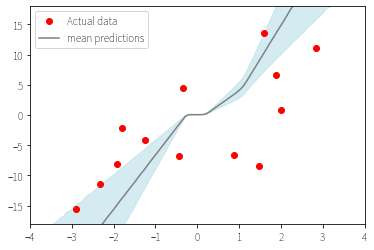

testing time = 15.508059978485107 seconds

Mean = tensor([-22.8427, -22.4167, -21.9907, -21.5647, -21.1386, -20.7127, -20.2881,
        -19.8720, -19.4558, -19.0396, -18.6234, -18.2175, -17.8214, -17.4253,
        -17.0292, -16.6330, -16.2370, -15.8387, -15.4376, -15.0365, -14.6353,
        -14.2342, -13.8330, -13.4246, -12.9928, -12.5609, -12.1892, -11.8274,
        -11.4563, -11.0692, -10.6820, -10.2947,  -9.9076,  -9.4922,  -9.0511,
         -8.6328,  -8.2138,  -7.7673,  -7.3353,  -6.9555,  -6.7605,  -6.5992,
         -6.4726,  -6.2933,  -5.9584,  -5.5652,  -5.2094,  -4.8035,  -4.3604,
         -3.9171,  -3.4287,  -2.9307,  -2.4835,  -1.9914,  -1.4808,  -1.0119,
         -0.5262,  -0.0255,   0.4748,   1.0306,   1.4880,   1.8376,   2.1221,
          2.4266,   2.7036,   2.9687,   3.2914,   3.6246,   3.9724,   4.1797,
          4.3167,   4.4405,   4.5468,   4.5853,   4.5745,   4.5519,   4.5293,
          4.5067,   4.4850,   4.4586,   4.4298,   4.4011,   4.3725,   4.3446,
          4.31

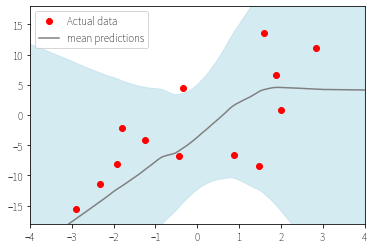

testing time = 14.920232772827148 seconds

Mean = tensor([-23.0112, -22.5805, -22.1499, -21.7192, -21.2886, -20.8579, -20.4288,
        -20.0077, -19.5865, -19.1653, -18.7441, -18.3332, -17.9321, -17.5308,
        -17.1297, -16.7285, -16.3273, -15.9239, -15.5173, -15.1108, -14.7042,
        -14.2976, -13.8910, -13.4773, -13.0408, -12.6042, -12.2280, -11.8619,
        -11.4865, -11.0951, -10.7036, -10.3121,  -9.9206,  -9.5009,  -9.0555,
         -8.6328,  -8.2112,  -7.7625,  -7.3289,  -6.9498,  -6.7563,  -6.5977,
         -6.4745,  -6.2982,  -5.9641,  -5.5718,  -5.2185,  -4.8157,  -4.3757,
         -3.9359,  -3.4515,  -2.9574,  -2.5141,  -2.0247,  -1.5153,  -1.0476,
         -0.5634,  -0.0665,   0.4289,   0.9811,   1.4357,   1.7832,   2.0660,
          2.3690,   2.6446,   2.9081,   3.2293,   3.5611,   3.9066,   4.1100,
          4.2427,   4.3624,   4.4644,   4.4987,   4.4837,   4.4568,   4.4298,
          4.4029,   4.3768,   4.3459,   4.3127,   4.2796,   4.2464,   4.2136,
          4.18

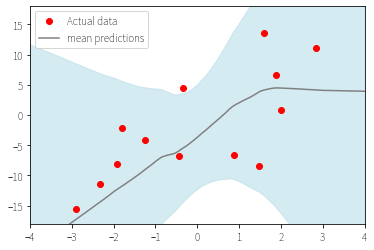

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

for _, network in uncertainty_methods.items():

    """
    Testing
    """

    # Model to eval mode
    network.eval()

    # Record testing start time (for this split)
    tic_testing = time.time()    
    
    predictions, mean, var, metrics = network.predict_dist(X_test, 10000)
    
    # Record testing end time
    toc_testing = time.time()
    
    # Report the total testing time
    print("testing time = " + str(toc_testing - tic_testing) + " seconds")
    
    """
    Print results
    """
    print()
    print("Mean = " + str(mean.flatten()))
    print("Variance = " + str(var.flatten()))
    
    # store additional metrics
    if len(metrics) > 0:
        for key, value in metrics.items():
            print(str(key) + " = " + str(value))
        print()
             
    # Plot the uncertainty measured by each methods
    plt.figure()
    
    # Fix the scales of x-axis and y-axis
    plt.xlim(dataset_toy_x_low, dataset_toy_x_high)
    plt.ylim(dataset_toy_y_mean-2*dataset_toy_y_std, dataset_toy_y_mean+2*dataset_toy_y_std)

    # Train data
    plt.plot(dataset.data_x, dataset.data_y, 'or', label='Actual data')

    # MC prediction
    plt.plot(X_test, mean.detach().numpy(), 'gray', label='mean predictions')

    # Distributions around the predictions
    plt.fill_between(X_test.flatten(), (mean.detach().numpy() - 2*torch.sqrt(var).detach().numpy()).flatten(), (mean.detach().numpy() + 2*torch.sqrt(var).detach().numpy()).flatten(),
                     color='lightblue', alpha=0.5)
    
    plt.legend()
    
    plt.show()